# Business Data Analytics

## Solutions for Homework 3 - Text Mining

**Author:** Kamran Mammadzada

The notebook contains solutions for Homework 3 - Text Mining topic in Business Data Analytics Course taught by Rajesh Sharma - University of Tartu.

__Task:__ We will use Airlines dataset to perform text mining.

### Data Preparation & Libraries

First we need to load the necessary libraries and the dataset.

In [46]:
# load all necessary libraries
library(tm) # Text mining: Corpus and Document Term Matrix
library(class) # KNN model
library(tidyverse) # tidyverse
library(lubridate) # helps with date manipulation
library(wordcloud) # wordcloud library
library(wordcloud2) # another wordcloud library
library(syuzhet) # library necessary for sentiment analysis
library(ggplot2) # ggplot2 for visualization
library(ggmap) # ggmap for mapping
library(gridExtra) # grid
library(rpart) # decision trees
library(randomForest) # random Forest
library(caret) # for easier confusion matrices
set.seed(222) # set seed for reproducibility
options(warn=-1)

In [47]:
# load dataset
dt <- read.csv("airlines.csv")
str(dt) # check dataset

'data.frame':	14640 obs. of  15 variables:
 $ tweet_id                    : num  5.7e+17 5.7e+17 5.7e+17 5.7e+17 5.7e+17 ...
 $ airline_sentiment           : Factor w/ 3 levels "negative","neutral",..: 2 3 2 1 1 1 3 2 3 3 ...
 $ airline_sentiment_confidence: num  1 0.349 0.684 1 1 ...
 $ negativereason              : Factor w/ 11 levels "","Bad Flight",..: 1 1 1 2 3 3 1 1 1 1 ...
 $ negativereason_confidence   : num  NA 0 NA 0.703 1 ...
 $ airline                     : Factor w/ 6 levels "American","Delta",..: 6 6 6 6 6 6 6 6 6 6 ...
 $ airline_sentiment_gold      : Factor w/ 4 levels "","negative",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ name                        : Factor w/ 7701 levels "___the___","__betrayal",..: 1073 3477 7666 3477 3477 3477 1392 5658 1874 7665 ...
 $ negativereason_gold         : Factor w/ 14 levels "","Bad Flight",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ retweet_count               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ text                        : Factor w/ 14427 levels "\"LOL you gu

In [48]:
names(dt) # check dataset columns

[1] "tweet_id"                     "airline_sentiment"           
 [3] "airline_sentiment_confidence" "negativereason"              
 [5] "negativereason_confidence"    "airline"                     
 [7] "airline_sentiment_gold"       "name"                        
 [9] "negativereason_gold"          "retweet_count"               
[11] "text"                         "tweet_coord"                 
[13] "tweet_created"                "tweet_location"              
[15] "user_timezone"

Our dataset contains tweets across multiple airlines. We will explore our dataset both from the perspective of the overall sentiment towards the airlines as well as for each airline to get a deeper understanding of the thoughts and feeling towards the airlines.

Before we proceed with visualization, I wrote a function which takes a dataset and performs the following operations

1. filter only tweet text and conver to utf 8 for compatibility
2. vectorize the corpus data
3. perform various clean ups

In [49]:
airlines <- c('virginamerica', 'united', 'southwestair', 
            'usairways', 'americanair', 'jetblue')

# function to preprocess and clean text
process_text <- function(d, al = airlines) {
  d$text <- sapply(d$text,function(row) iconv(row, "latin1", "ASCII", sub="")) # remove emoticons and non ASCII characters
  tweets <- iconv(d$text, to = 'utf-8') # for windows
  corpus <- Corpus(VectorSource(tweets)) # vectorize the corpus data
  corpus <- tm_map(corpus, tolower) # lower all cases for words
  corpus <- tm_map(corpus, removePunctuation) # remove punctuation
  corpus <- tm_map(corpus, removeNumbers) # remove numbers
  cl <- tm_map(corpus, removeWords, stopwords('english')) # remove stopwords of the english language
  removeURL <- function(x) gsub('http[[:alnum:]]*', '', x)
  cl <- tm_map(cl, content_transformer(removeURL)) # remove urls from tweet text
  cl <- tm_map(cl, stripWhitespace) # let's strip extra whitespaces
  cl <- tm_map(cl, removeWords, al) # remove names of airlines from tweets
  return(cl) # returned processed corpus
}

We will be using airline_sentiment as our label and use it to predict the sentiment. Currently the dataset has three unique values for sentiment. We will convert neutral to negative.

In [50]:
# check unique values for sentiment
unique(dt$airline_sentiment)

# change neutral to negative for simplicity
levels(dt$airline_sentiment)[levels(dt$airline_sentiment) == "neutral"] <- "negative"

# check the change
unique(dt$airline_sentiment)

[1] neutral  positive negative
Levels: negative neutral positive

[1] negative positive
Levels: negative positive

## All Airlines Analysis

In order to better understand the twitter data, we will use some visualization tools (plots) to get a better feel of our dataset.

### Visualization

We will first visualize tweet data for all airlines, and see what are the most common words across airlines

#### Word Clouds

Let's use word clouds and visually see the most popular words across the dataset.

In [51]:
# process and clean all tweet text
cleanset_all <- process_text(dt)

To proceed with visualization we need to first create a Term Document Matrix.

In [52]:
tdm_all <- TermDocumentMatrix(cleanset_all)
tdm_all # check
tdm_all <- as.matrix(tdm_all) # convert to matrix
tdm_all[1:20, 1:20] # check

<<TermDocumentMatrix (terms: 13010, documents: 14640)>>
Non-/sparse entries: 125025/190341375
Sparsity           : 100%
Maximal term length: 46
Weighting          : term frequency (tf)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
dhepburn,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
said,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
added,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
commercials,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
experience,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
plus,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tacky,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
youve,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
another,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
didnt,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Word clouds are a good interactive way to check for word ocurrences.

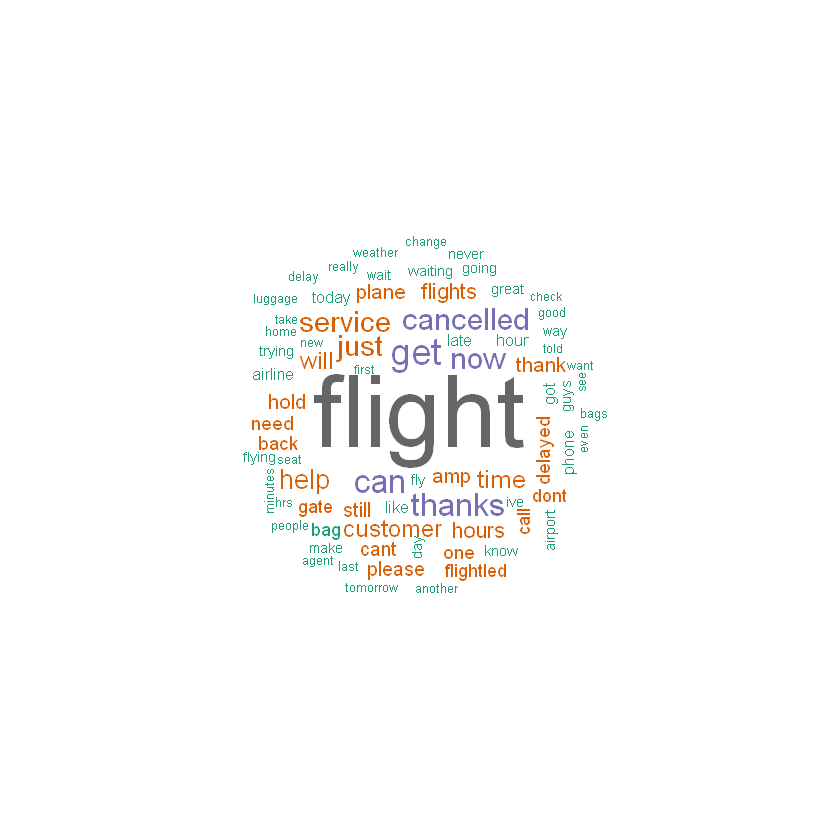

In [53]:
# sort words by number of occurences
w1 <- sort(rowSums(tdm_all), decreasing = TRUE)

# wordcloud with most words in horizontal and min word freq of 350
wordcloud(words = names(w1), freq = w1,
          max.words = 150, random.order = F,
          min.freq = 250, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.3), rot.per = 0.1)

Let's use another wordcloud which is more interactive and shows number of ocurrences when hovered over to get a better feel of our dataset.

In [54]:
# create a dataframe with words and their ocurrence
w <- data.frame(names(w1), w1)

# change column names
colnames(w) <- c('word', 'freq')

# main wordcloud function
wordcloud2(w, size = 0.8, shape = 'circle',
           rotateRatio = 0.5, minSize = 1)

HTML widgets cannot be represented in plain text (need html)

Based on the two wordclouds, just visually, it seems that the most common words across the dataset are __flight__, __help__, __thanks__, __service__, __cancelled__, __now__, __customer__ and etc. We can speculate that most of the tweets concern the quality of flights or customer service for all airlines and it might be that people usually take it to twitter when they want to point a deficiency in service or need help with their flight or just are really not happy with the service due to cancelled flights. Let's use barplots to better visualize the ocurrence of words.

### Bar Plots

In [55]:
w <- rowSums(tdm_all) # get all terms

# check the max number of word ocurrences and min number
min(w)
max(w)

[1] 1

[1] 3895

It seems that there are words with 1 ocurrence and there is a word with 3892 ocurrence. We need to a threshold to visualize the bar plot. We will use 350 occurences as a threshold.

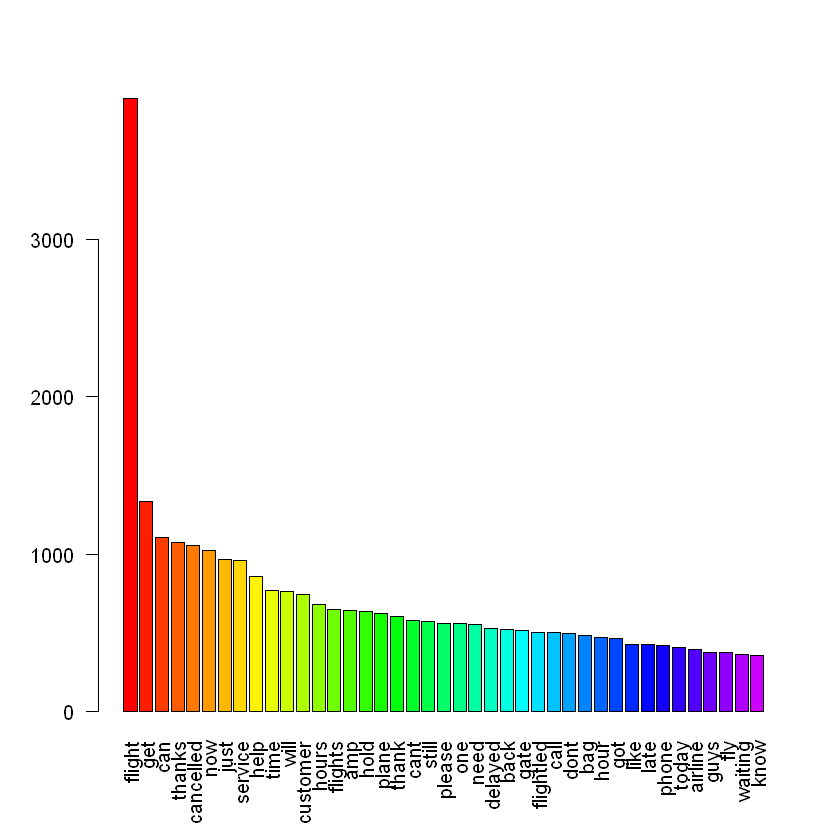

In [56]:
w <- subset(w, w>=350) # filter the ones that have more than 350 count

# sort words by number of occurences for bar plot
w <- sort(w, decreasing = TRUE)

# visualiza a barplot
barplot(w, las = 2, col = rainbow(50))

### Sentiment Analysis & Visualization

We can now use the data to perform sentiment analysis. As part of this we will also visualize sentiments using SentiBar.

In [57]:
# we will use our tweet text
twts <- iconv(dt$text, to = 'utf-8') # for windows

# get sentiment main function
score_all <- get_nrc_sentiment(twts)

# check
head(score_all)

anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0
3,1,1,2,1,1,2,1,3,1
1,0,1,1,0,1,0,0,1,0
1,1,1,2,1,1,0,1,1,2


### Bar plot - Senti Bar

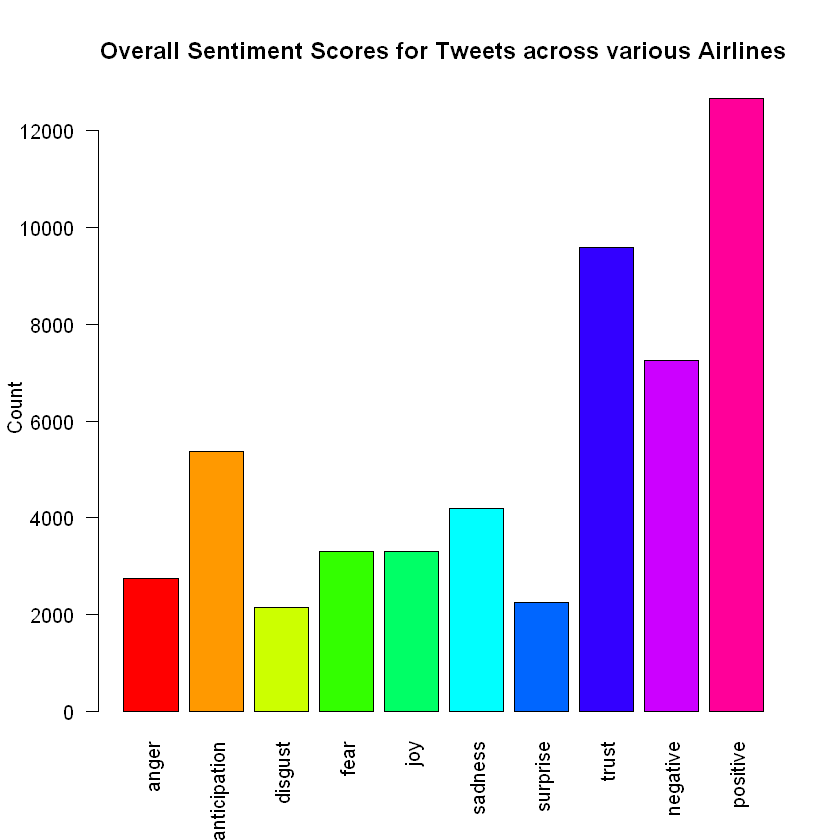

In [58]:
# plot all twitter text 
barplot(colSums(score_all), las = 2,
       col = rainbow(10), ylab = 'Count',
       main = 'Overall Sentiment Scores for Tweets across various Airlines')

We can see from the sentiment scores that most of the tweets from all airlines' twitter pages are _positive_, with second most being about trust and third most being negative.


# Individual Airlines Analysis

To get a more granular understanding of our tweets we will visualize the dataset for each airlines separately and see how does each airlines stand on its own. Since we have 6 airlines we will create 6 different datasets and visualize them separately.

First it would be interesting to see the distribution of tweets in our dataset.

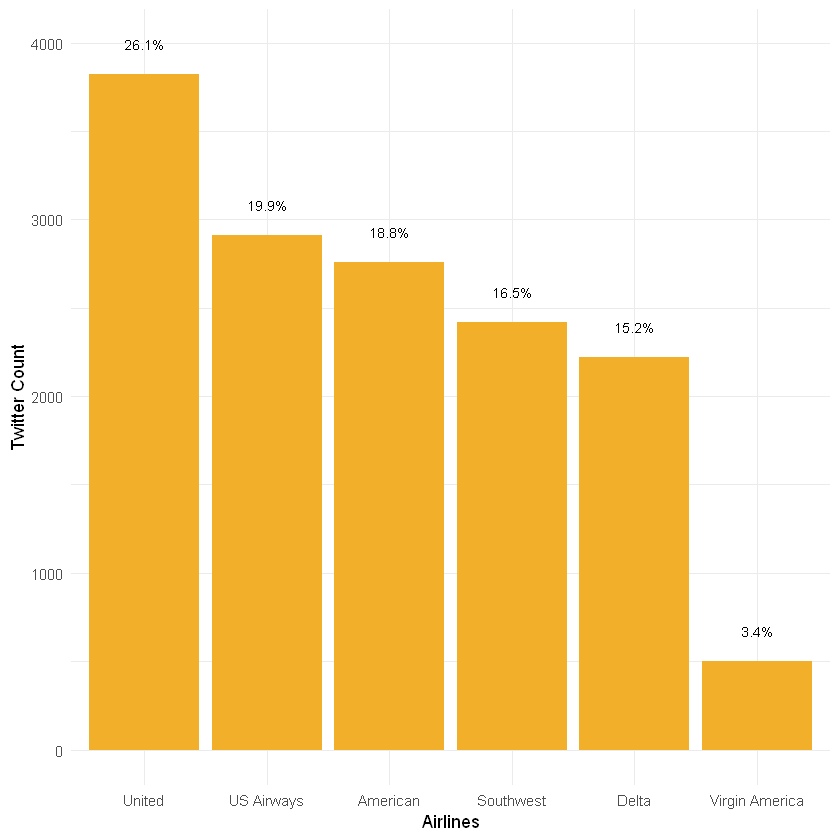

In [59]:
dt %>%
  group_by(airline) %>%
  summarise(tw_count = n()) %>%
  mutate(pct = prop.table(tw_count) * 100) %>%
  ggplot(aes(x=reorder(airline, -tw_count), y=tw_count))+
    geom_bar(stat = "identity", position = "dodge",
             fill = "#F2AF29") +
    geom_text(aes(y = tw_count + 170, 
                  label = paste0(round(pct,1), '%')),
              position = position_dodge(width = 0.9),
              size = 3) +
    theme_minimal() +
    labs(x="Airlines", y="Twitter Count")

We can see that majority of tweets from United followed by US Airways and American airlines.

In [60]:
# filter dataset for each airline
# first let's only choose airline and tweet columns to avoid extra data processing
dtnew <- select(dt, c("airline", "text"))

# Virgin America tweets
dt_virgin <- filter(dtnew, airline == 'Virgin America')

# United Airlines tweets
dt_united <- filter(dtnew, airline == 'United')

# Southwest tweets
dt_south <- filter(dtnew, airline == 'Southwest')

# Delta tweets
dt_delta <- filter(dtnew, airline == 'Delta')

# US Airways tweets
dt_usair <- filter(dtnew, airline == 'US Airways')

# American airlines tweets
dt_american <- filter(dtnew, airline == 'American')

Now that we have all of the tweets for each airline we can visualize wordcloud for each of them and see how different airlines twitter responses look like.

Please note that moving forward the data will be in the following order

1. Virgin America
2. United
3. Southwest
4. Delta
5. US Airways
6. American Air

In [61]:
# create one list of dataframes of airline tweets to make bulk operations easier
l.df <- lapply(ls(pattern="dt_"), function(x) get(x))

# apply process_text to each dataframe, receive list of clean corpuses for each airline
l.dt <- lapply(l.df, process_text)

### Visualizations

Let's visualize word clouds for each airline separately and in order to save space, put them in a grid. We will use wordcloud used above due to its simplicity.

In [62]:
# create Term Document Matrices for all of the corpuses
l.c <- sapply(lapply(l.dt, TermDocumentMatrix), as.matrix)

# sort words by number of occurences for each airline in the list of matrices
l.oc <- lapply(lapply(l.c, rowSums), sort, decreasing = TRUE)

# for 1 row, 2 cols
par(mfrow=c(1,1))

> Virgin Airlines and United

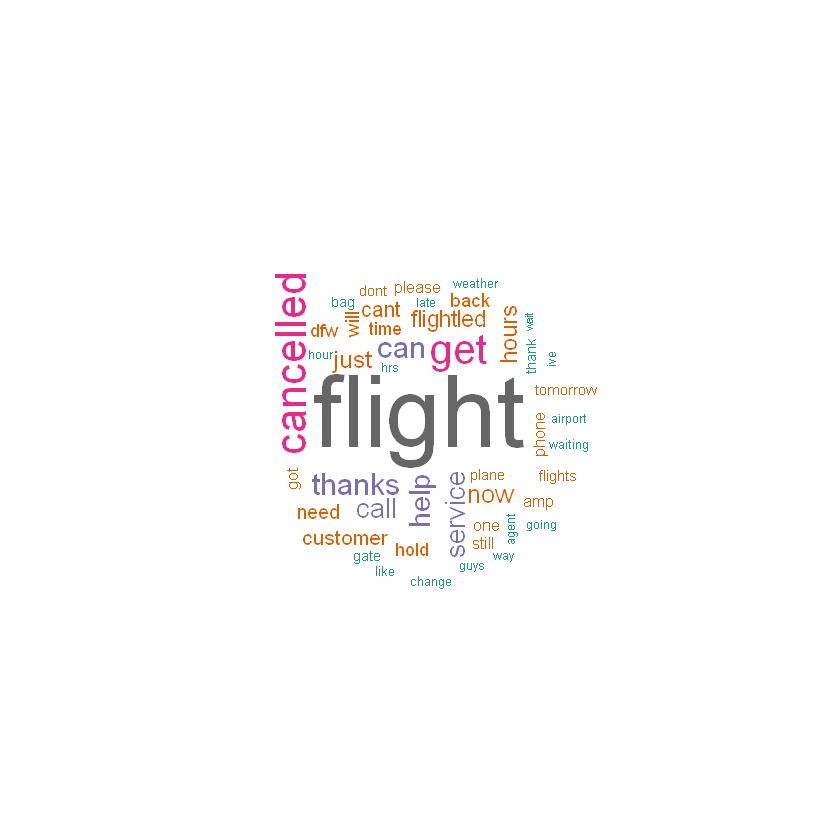

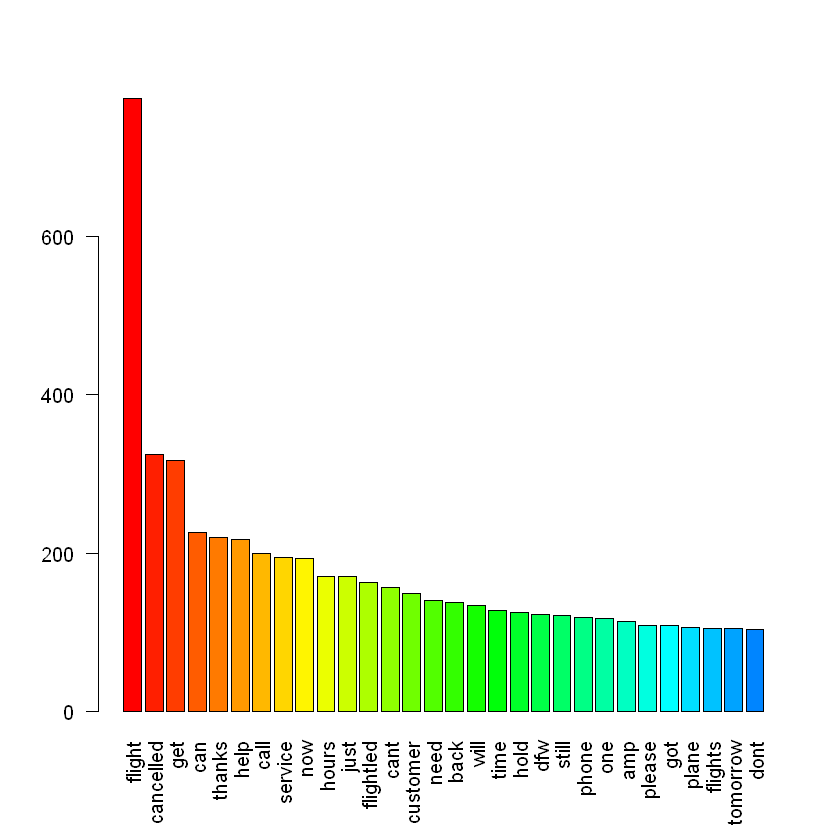

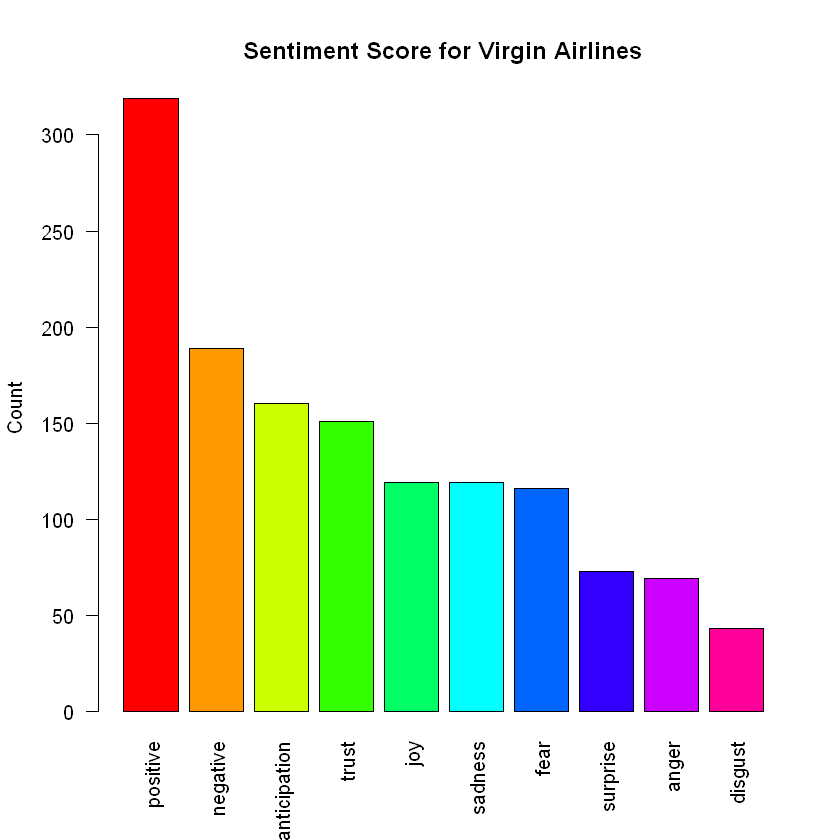

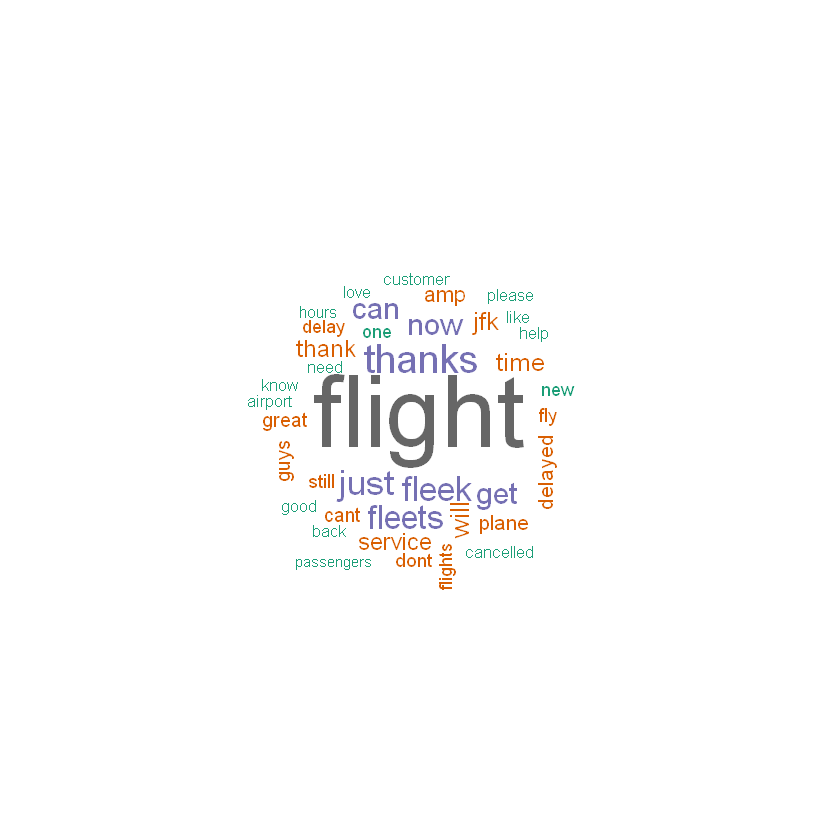

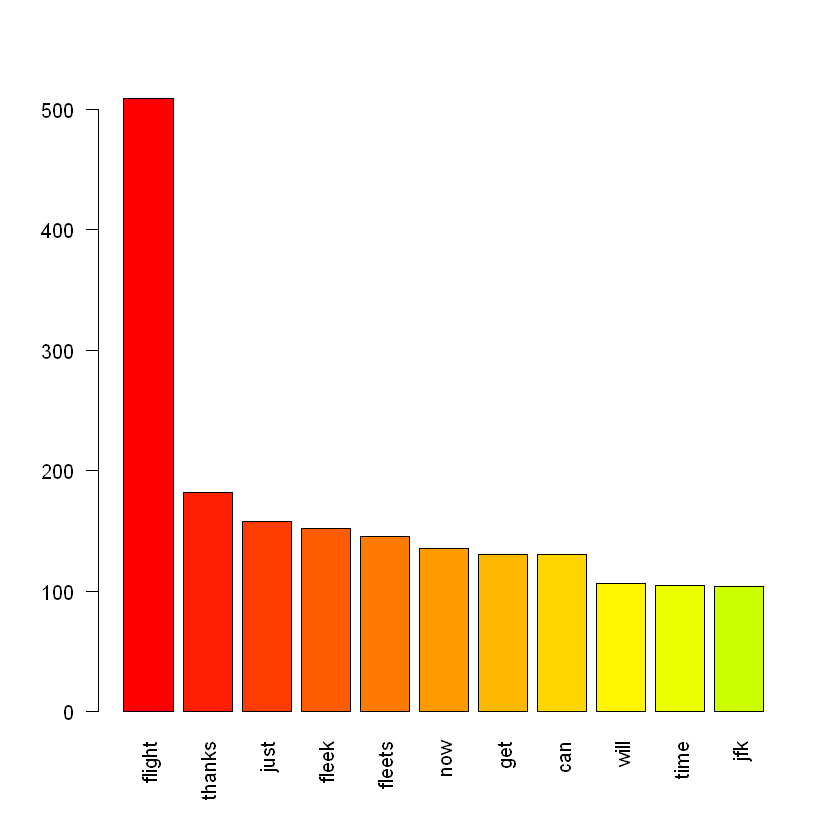

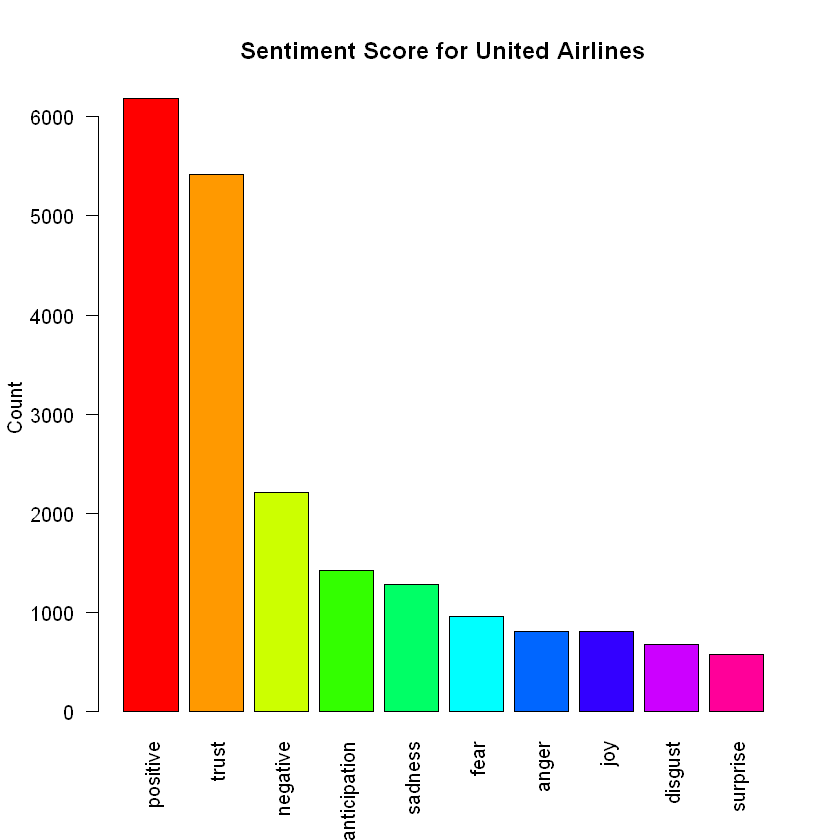

In [63]:
# wordcloud for Virgin Airlines
wordcloud(words = names(l.oc[[1]]), freq = l.oc[[1]],
          max.words = 150, random.order = F,
          min.freq = 75, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.1), rot.per = 0.3)

# barplot for Virgin Airlines
barplot(subset(l.oc[[1]], l.oc[[1]]>=100), las = 2, col = rainbow(50))

# sentibar for Virgin Airlines
sent <- iconv(dt_virgin$text, to = 'utf-8') # we will use our tweet text for virgin
score <- get_nrc_sentiment(sent) # get sentiment main function
barplot(sort(colSums(score), decreasing = T), las = 2,
        col = rainbow(10), ylab = 'Count',
        main = 'Sentiment Score for Virgin Airlines')


# worcloud for United
wordcloud(words = names(l.oc[[2]]), freq = l.oc[[2]],
          max.words = 150, random.order = F,
          min.freq = 50, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.3), rot.per = 0.1)

# barplot for United
barplot(subset(l.oc[[2]], l.oc[[2]]>=100), las = 2, col = rainbow(50)) # barplot

# sentibar for United
sent <- iconv(dt_united$text, to = 'utf-8') # we will use our tweet text for united
score <- get_nrc_sentiment(sent) # get sentiment main function
barplot(sort(colSums(score), decreasing = T), las = 2,
        col = rainbow(10), ylab = 'Count',
        main = 'Sentiment Score for United Airlines')

> Southwest Airlines and United Airlines

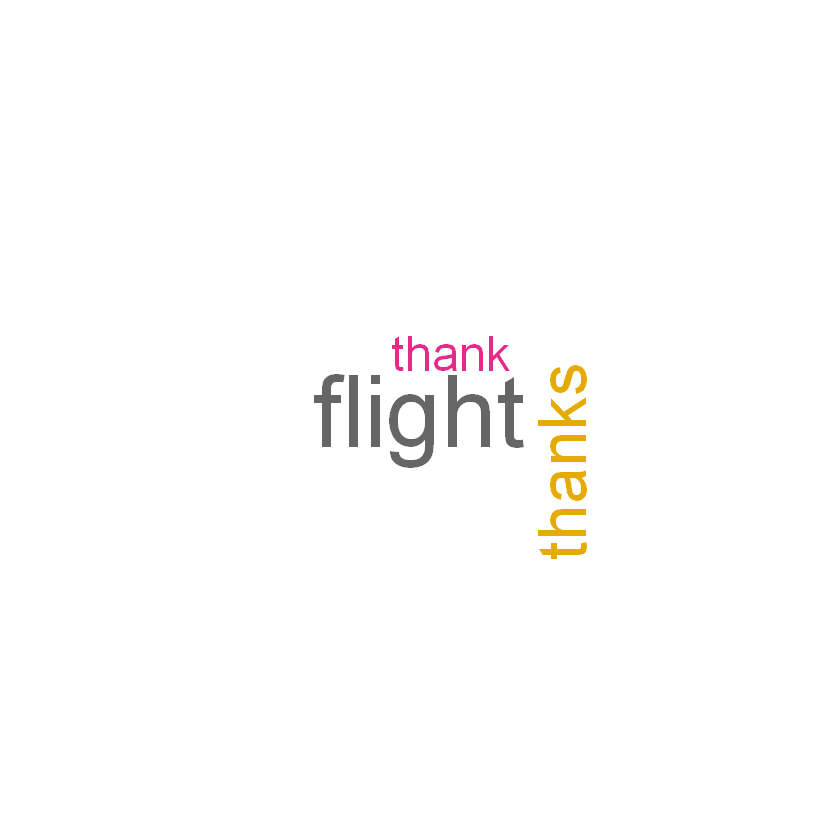

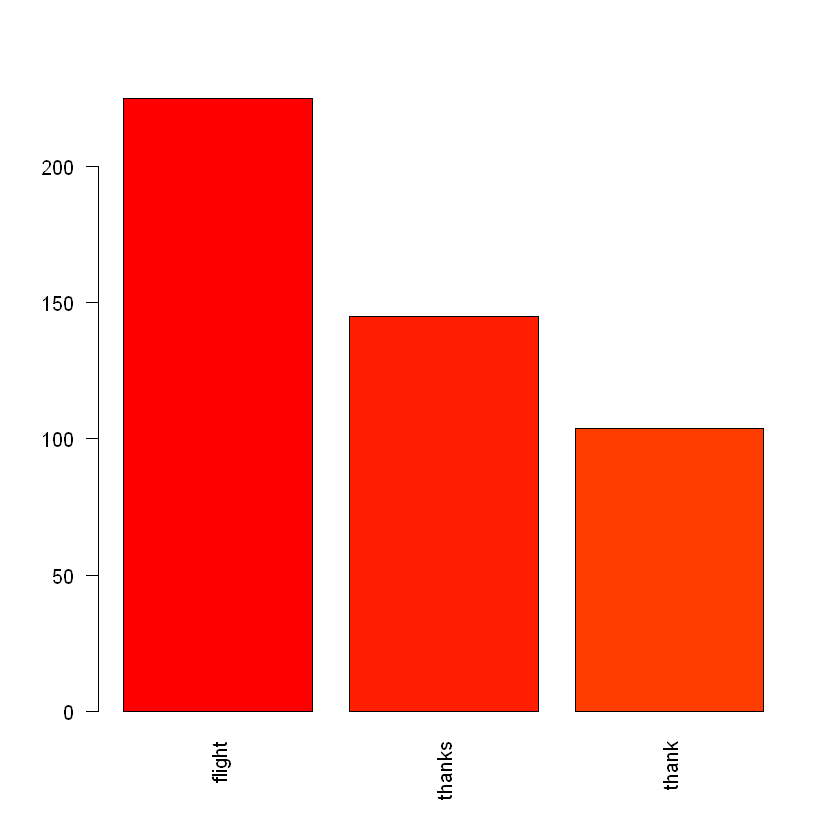

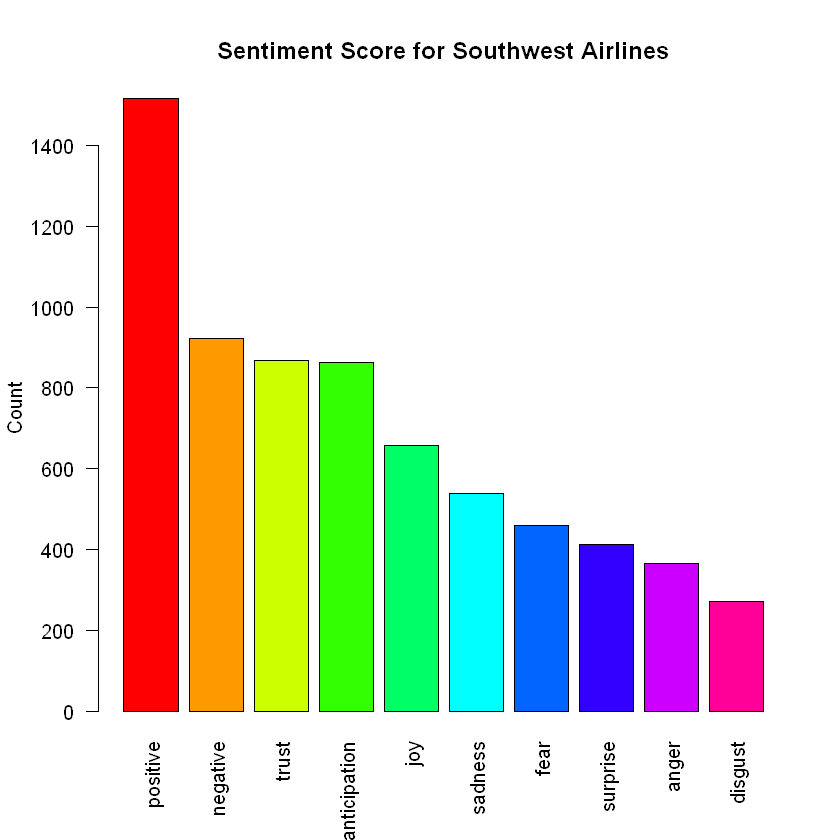

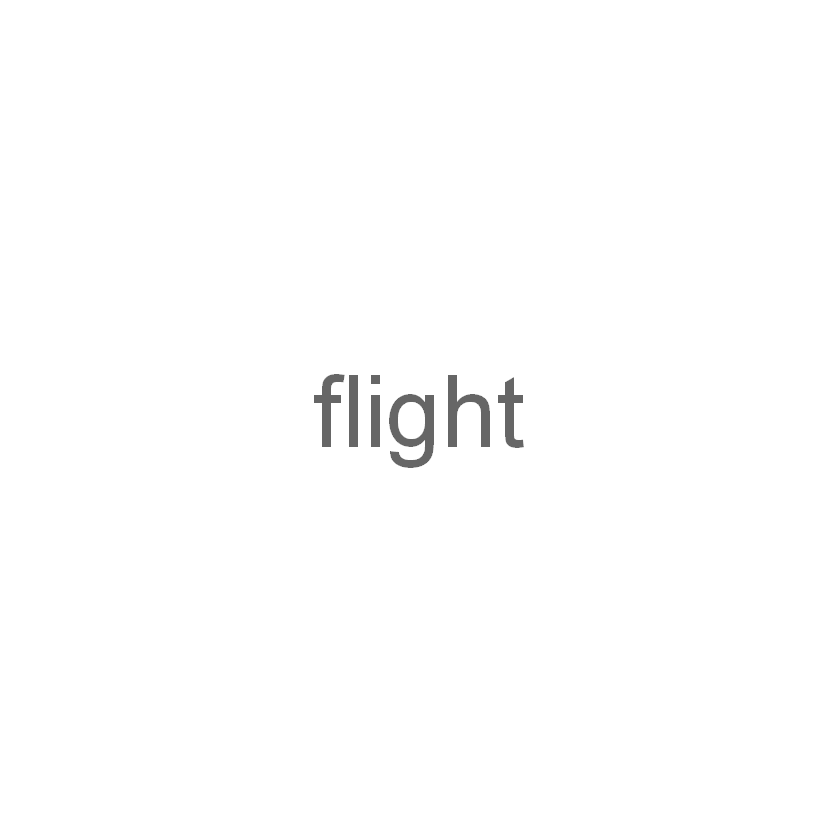

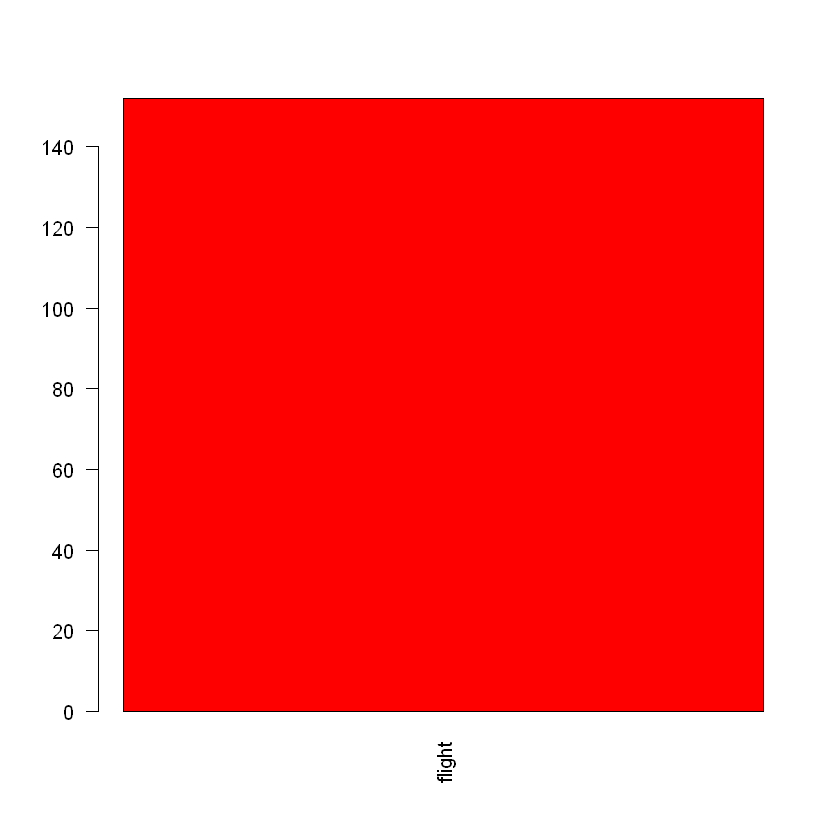

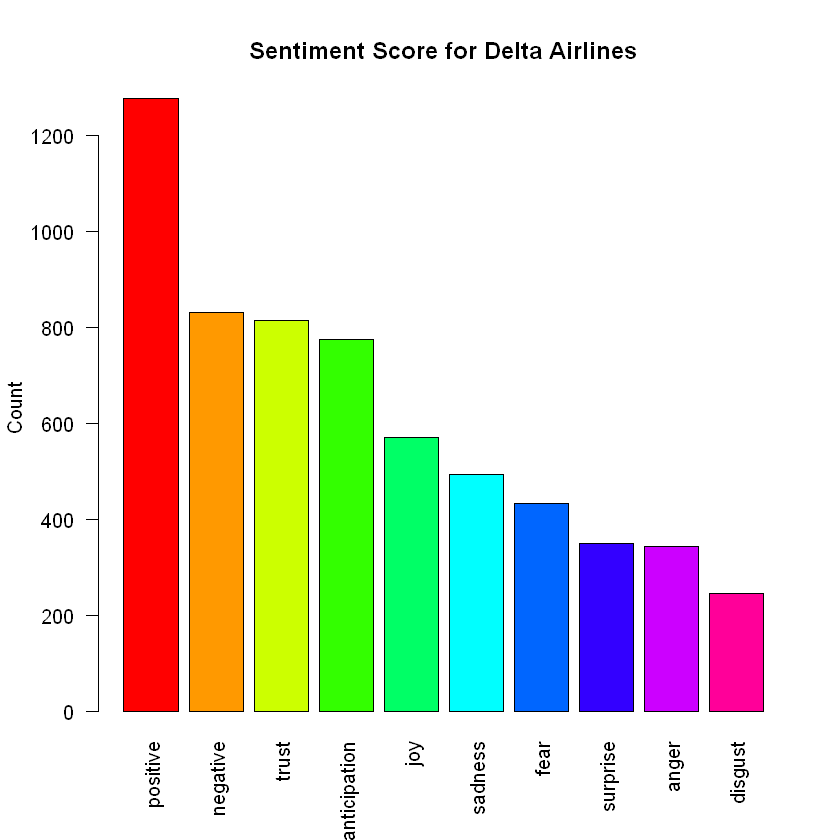

In [64]:
# worcloud for Southwest
wordcloud(words = names(l.oc[[3]]), freq = l.oc[[3]],
          max.words = 150, random.order = F,
          min.freq = 85, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.3), rot.per = 0.1)

# barplot for Southwest
barplot(subset(l.oc[[3]], l.oc[[3]]>=85), las = 2, col = rainbow(50)) # barplot

# sentibar for Southwest
sent <- iconv(dt_south$text, to = 'utf-8') # we will use our tweet text for southwest
score <- get_nrc_sentiment(sent) # get sentiment main function
barplot(sort(colSums(score), decreasing = T), las = 2,
        col = rainbow(10), ylab = 'Count',
        main = 'Sentiment Score for Southwest Airlines')

# worcloud for Delta
wordcloud(words = names(l.oc[[4]]), freq = l.oc[[4]],
          max.words = 150, random.order = F,
          min.freq = 90, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.3), rot.per = 0.1)

# barplot for Delta
barplot(subset(l.oc[[4]], l.oc[[4]]>=115), las = 2, col = rainbow(50)) # barplot

# sentibar for Delta
sent <- iconv(dt_delta$text, to = 'utf-8') # we will use our tweet text for delta
score <- get_nrc_sentiment(sent) # get sentiment main function
barplot(sort(colSums(score), decreasing = T), las = 2,
        col = rainbow(10), ylab = 'Count',
        main = 'Sentiment Score for Delta Airlines')

> US Airways and American

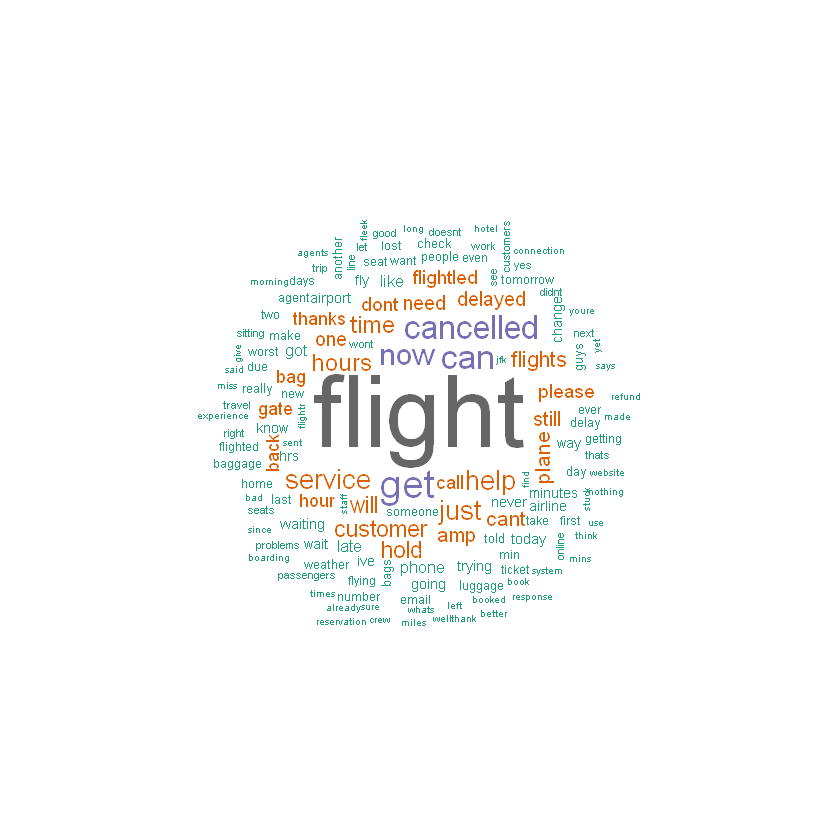

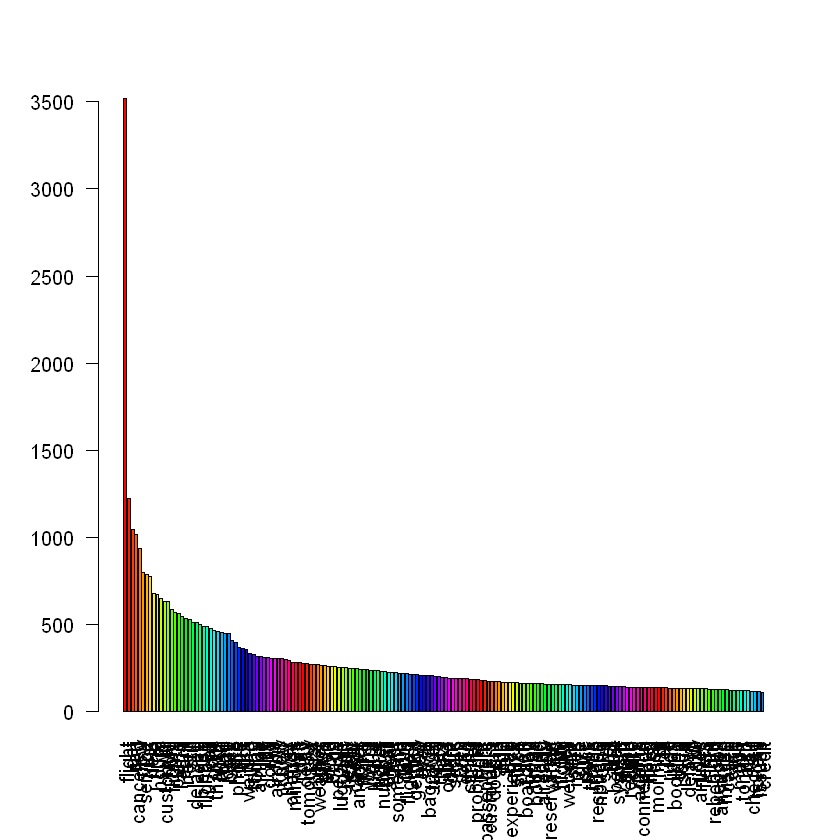

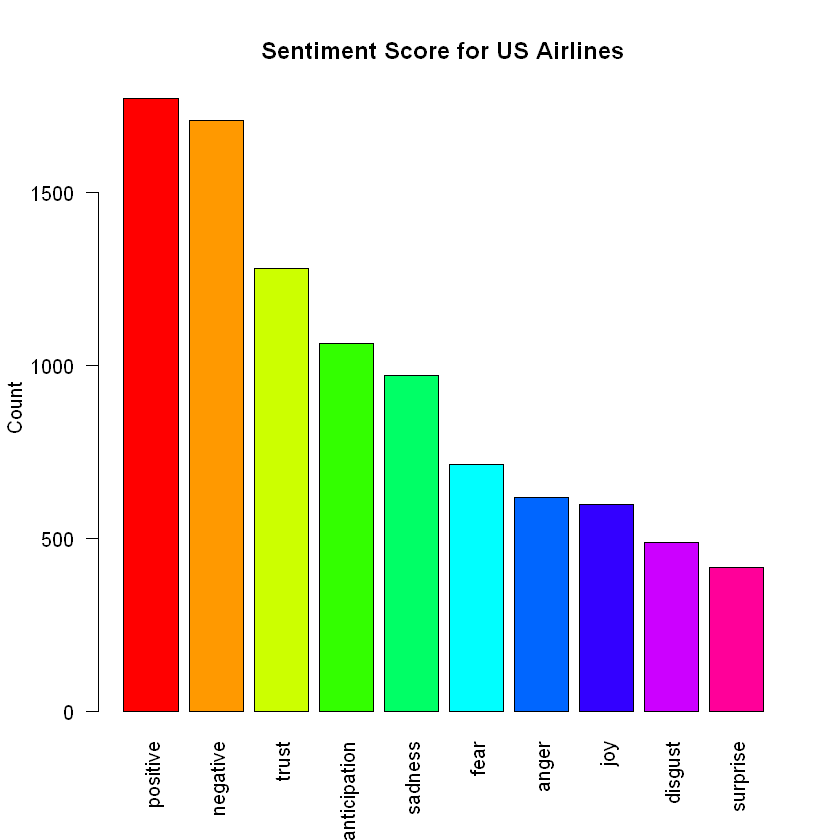

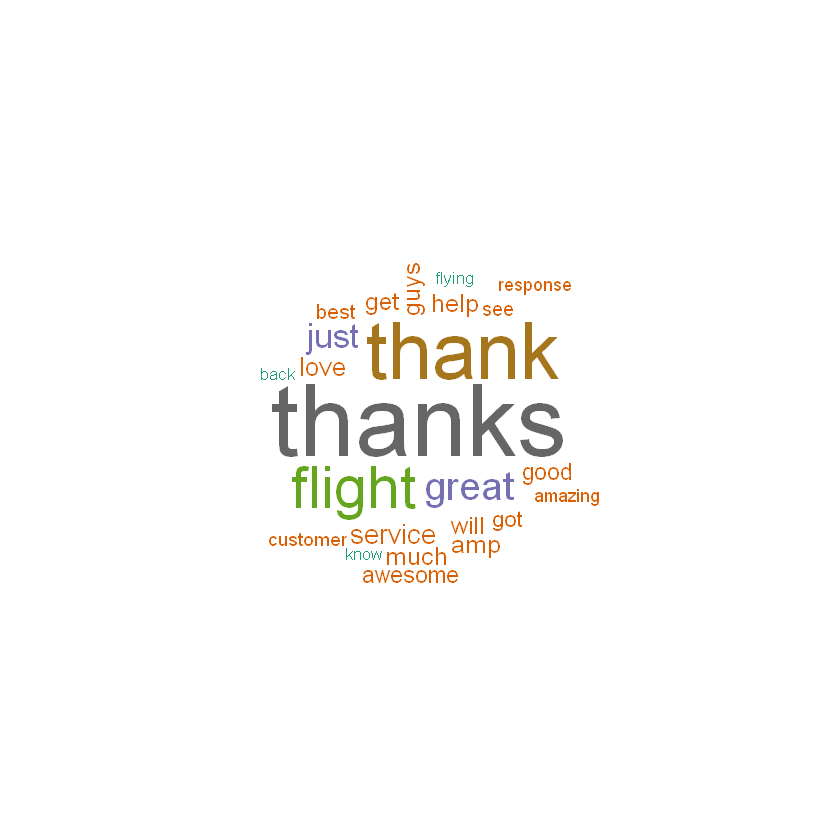

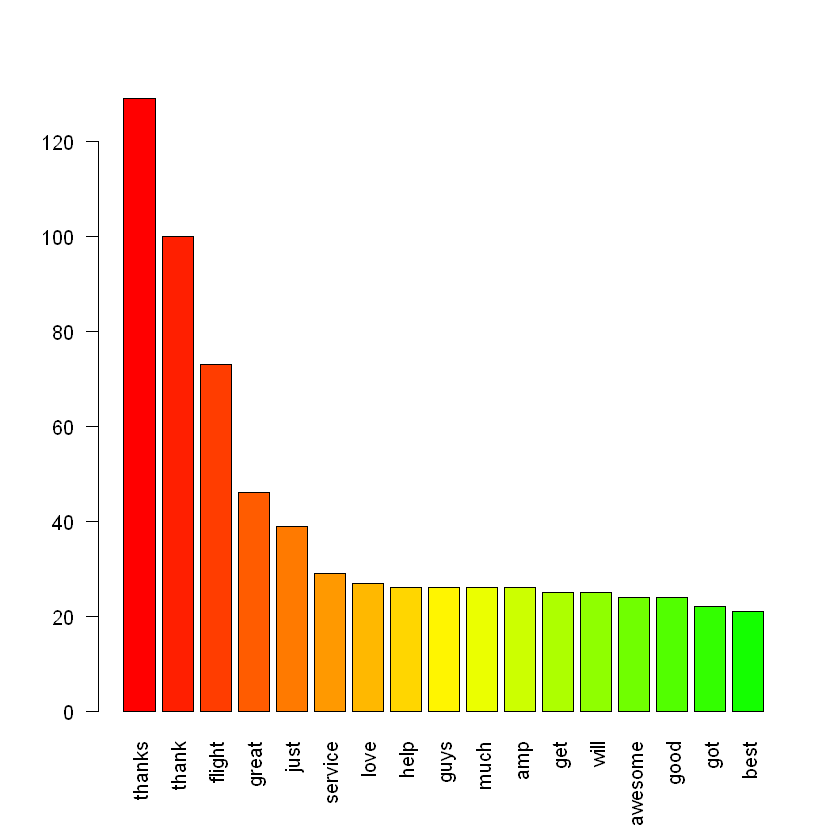

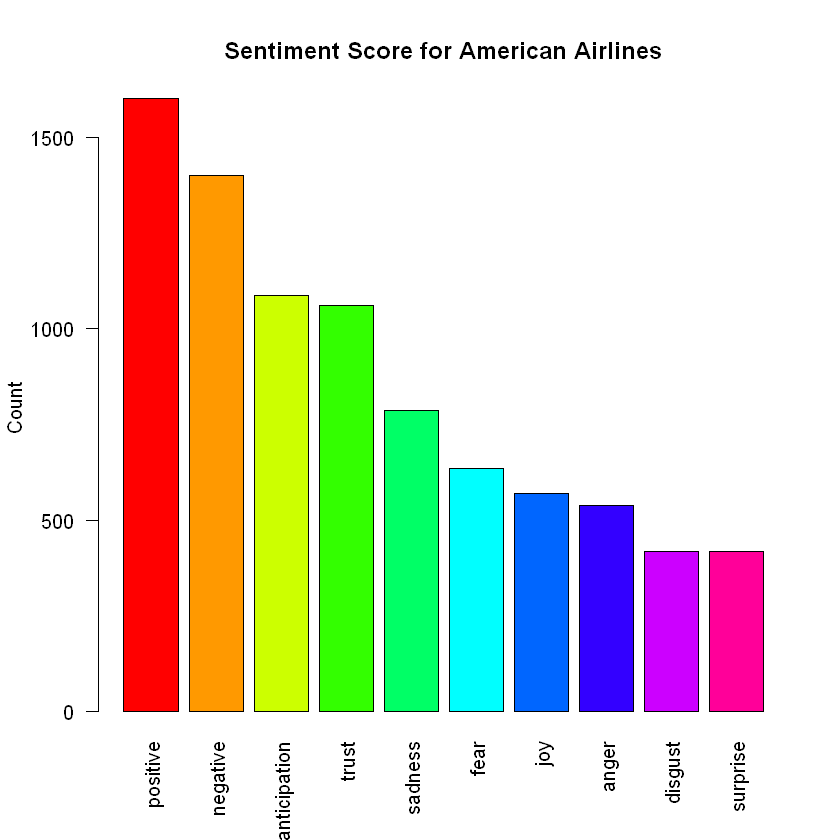

In [65]:
# worcloud for US Airways
wordcloud(words = names(l.oc[[5]]), freq = l.oc[[5]],
          max.words = 150, random.order = F,
          min.freq = 75, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.3), rot.per = 0.1)

# barplot for US Airways
barplot(subset(l.oc[[5]], l.oc[[5]]>=110), las = 2, col = rainbow(50)) # barplot

# sentibar for US Airways
sent <- iconv(dt_usair$text, to = 'utf-8') # we will use our tweet text for us airways
score <- get_nrc_sentiment(sent) # get sentiment main function
barplot(sort(colSums(score), decreasing = T), las = 2,
        col = rainbow(10), ylab = 'Count',
        main = 'Sentiment Score for US Airlines')

# worcloud for American
wordcloud(words = names(l.oc[[6]]), freq = l.oc[[6]],
          max.words = 150, random.order = F,
          min.freq = 15, colors = brewer.pal(8, 'Dark2'),
          scale = c(5, 0.3), rot.per = 0.1)

# barplot for American
barplot(subset(l.oc[[6]], l.oc[[6]]>=20), las = 2, col = rainbow(50)) # barplot

# sentibar for American
sent <- iconv(dt_american$text, to = 'utf-8') # we will use our tweet text for american
score <- get_nrc_sentiment(sent) # get sentiment main function
barplot(sort(colSums(score), decreasing = T), las = 2,
        col = rainbow(10), ylab = 'Count',
        main = 'Sentiment Score for American Airlines')

> Summary

According to the above visualization it is seen that overall across airlines with the exception of __US Airlines__ and __American Airlines__, people usually tweeted positive messages about the airlines. In case of __US Airlines__ and __American Airlines__ it seems that number of negaitve and positive tweets are almost the same, indicating that maybe customers feelings towards those two airlines based on our dataset is not that great. For __US Airlines__ this negative feedback seems comes primarily from customers not being able to get hold of the customer support / service since __get__, __hold__, __service__ words seems to come up very often.

Another interesting observation is that despite having quite high number of __cancelled__ words in the tweets, Virgin Airlines customers tweets are mostly positive. This might be due to incorrect sentiment analysis by the package or maybe that the tweets regarding __cancelled__ flights are mostly stating the fact with emoticons.

Customer of __United Airlines__ seem to show trust towards the brand, despite __cancelled__ being a common words used in the tweets.


# GeoMapping of airlines' tweets

There are three airlines tweet data represented in the dataset.

In [66]:
unique(dt$airline)

[1] Virgin America United         Southwest      Delta          US Airways    
[6] American      
Levels: American Delta Southwest United US Airways Virgin America

As it can be seen from below, there are quite a lot of missing coordinate values in our dataset. We will only plot those data points which we have coordinates for. In order to reduce the calculation time we will remove tweets with no coordinates.

In [67]:
# check number of tweets before
nrow(dt)

# let's copy our dataset
dt.fil <- dt

# convert coordinates to characters
dt.fil$tweet_coord <- as.character(dt.fil$tweet_coord)

# split the longitude and latitude data into separate column
dt.fil$lon <- sapply(strsplit(dt.fil$tweet_coord, ","), "[", 2)
dt.fil$lat <- sapply(strsplit(dt.fil$tweet_coord, ","), "[", 1)

# remove NA values
dt.fil <- filter(dt.fil, !is.na(lat), !is.na(lon))

# clean lon and lat data and convert to numeric
dt.fil$lon <- as.numeric(substr(dt.fil$lon, 1, nchar(dt.fil$lon)-1))
dt.fil$lat <- as.numeric(substr(dt.fil$lat, 2, nchar(dt.fil$lat)))

# remove 0s from lat and lon
dt.fil <- filter(dt.fil, lon != 0, lat != 0)

# number of tweets with coordinates
nrow(dt.fil)

# round the decimals of coordinates
dt.fil$lon <- round(dt.fil$lon, 4)
dt.fil$lat <- round(dt.fil$lat, 4)

[1] 14640

[1] 855

As it turns out there are only 855 tweets with coordinates out of 14640

Let's map the origin of the tweets with each airline having a different color (dot).

Source : https://maps.googleapis.com/maps/api/staticmap?center=36.526645,-85.55328&zoom=3&size=640x640&scale=2&maptype=satellite&language=en-EN&key=xxx


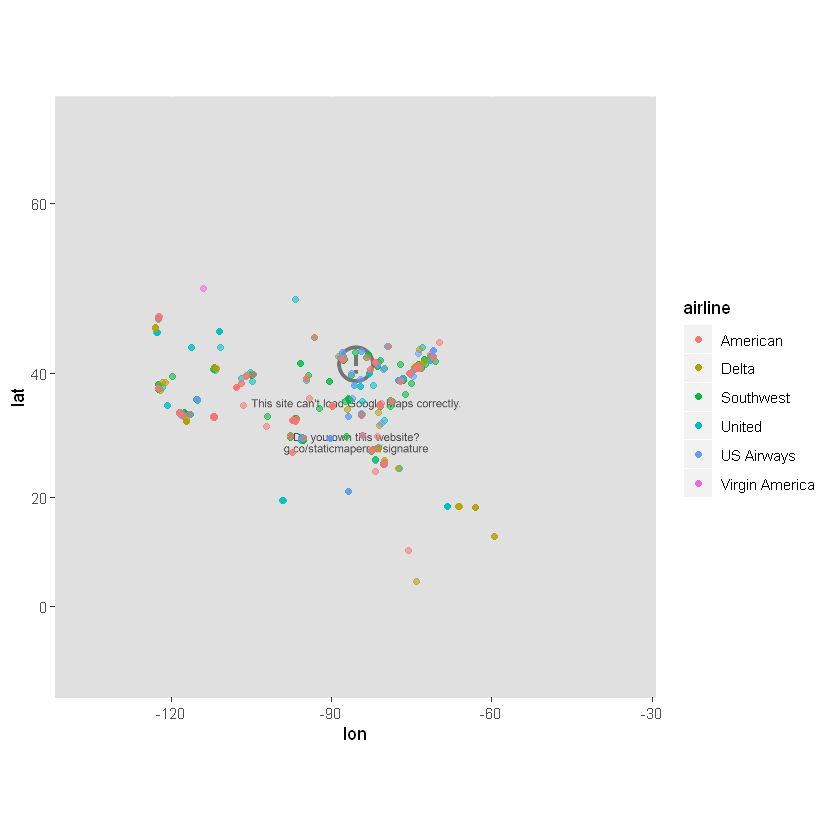

In [78]:
# register google key
register_google(key = "...")

# getting the map
map_airlines <- get_map(location = c(lon = mean(dt.fil$lon),
                                     lat = mean(dt.fil$lat)), zoom = 3,
                        maptype = "satellite", scale = 2)

# visualze the tweet locations
ggmap(map_airlines) +
    geom_point(data=dt.fil, aes(x=lon, y=lat, fill='red',
                                alpha=0.6, colour=airline)) +
    guides(fill=FALSE, alpha=FALSE)

The map is not very helpful but we can see that the primary location of 855 tweets we obtained is mostly from east coast US.

# Modeling - Sentiment Prediction

Up to now we have analyzed and visualized the text of tweets from the dataset. Now we will proceed with sentiment prediction and work with the full dataset as well as the corpuses and term document matrices.

Using the current dataset we can build a model to predict the sentiment for various airlines tweets using the historic data provided to us in the dataset.

## Dataset balance

Before we proceed with predictive modeling, let's check the balancedness of the model.

In [69]:
# check rows where sentiment is positive
np <- nrow(filter(dt, airline_sentiment == 1))
nn <- nrow(filter(dt, airline_sentiment == 0))

paste("Positive feedback tweets: ", np)
paste("Negative feedback tweets: ", nn)

[1] "Positive feedback tweets:  0"

[1] "Negative feedback tweets:  0"

We have 2363 (16% of all tweets) positive and 12277 (84% of all tweets) negative tweets. It would be good to try to balance them.

The dataset is quite large, thus we will divide the dataset as well as balance the dataset (perform undersampling).

In [70]:
# filter only positive tweets
dt_positive <- filter(dt, airline_sentiment == "positive")

# filter only negative tweets
dt_negative <- filter(dt, airline_sentiment == "negative")

# get a random sample of 2000 tweets from negatives to reduce the number of observations
n_ids <- sample(nrow(dt_negative), 500)
dt_neg <- dt_negative[n_ids, ]

# get a random sample of 2000 tweets from positives
p_ids <- sample(nrow(dt_positive), 500)
dt_pos <- dt_positive[p_ids, ]

# combine sampled datasets into one final
dt_fin <- rbind(dt_neg, dt_pos)

# clean and process data
cleanset_all <- process_text(dt_fin)

## K Nearest Neighbours

Let's first use a knn model to predict sentiment of airlines dataset.

We will stem our cleaned dataset, get Document Term Matrix and convert to dataframe. Then we will sample for train and test sets. We will also try to track the execution time of the model.

In [71]:
set.seed(222)

# stem the cleaned cleanset
docs <- tm_map(cleanset_all, stemDocument, language = "english")

# create Document Term Matrix
dtm <- DocumentTermMatrix(docs)

# convert tdm matrix into dataframe
dtm.df <- as.data.frame(data.matrix(dtm), stringsAsfactors = FALSE)

# bind the airline_sentiment column
dtm.df <- cbind(dtm.df, dt_fin$airline_sentiment)

# change column name to sentiment
colnames(dtm.df)[ncol(dtm.df)] <- "sentiment"

# split data to equal proportions (train and test)
train <- sample(nrow(dtm.df), max(nrow(dtm.df) / 2))
test <- (1:nrow(dtm.df))[- train]

# isolate classifier
cl <- dtm.df[,"sentiment"]

# create model data and remove "sentiment"
modeldata <- dtm.df[,!colnames(dtm.df) %in% "sentiment"]

start_time_knn <- Sys.time() # start time of knn model

# create model: training set, test set, training set classifier
knn.pred <- knn(modeldata[train, ], modeldata[test, ], cl[train], k=1)

end_time_knn <- Sys.time() # end time for knn
time_knn <- end_time_knn - start_time_knn

Using 1000 tweets, 50% for test and 50% for train and knn model we have an accuracy of 63% which is not that great.

__KNN Performance Metrics__

In [72]:
# confusion matrix with performance metrics
table(knn.pred, cl[test])

          
knn.pred   negative positive
  negative      207      107
  positive       36      150

* Accuracy is in decimals
* Sensitivity and Recall are same
* Precision and Pos Pred value are same

Let's use other modeling techniques and see their results.


## Decision Trees

When it comes to classification problems decision trees and random forests are good modeling techniques.

Here we will use a decision tree and evaluate our model.

In [73]:
start_time_dct <- Sys.time() # start time of knn model

# create a decision tree model
model_tree <- rpart(sentiment ~ ., data = dtm.df[train, ], method = "class")

end_time_dct <- Sys.time() # end time for knn

time_dct <- end_time_dct - start_time_dct

# summarize the model
summary(model_tree)

# generate predictions based on test data
dectree.pred <- predict(newdata=dtm.df[test, ],
                        model_tree, type = "class")

Call:
rpart(formula = sentiment ~ ., data = dtm.df[train, ], method = "class")
  n= 500 

          CP nsplit rel error    xerror       xstd
1 0.38271605      0 1.0000000 1.0000000 0.04599159
2 0.04115226      1 0.6172840 0.6172840 0.04216852
3 0.03703704      2 0.5761317 0.6049383 0.04192323
4 0.02469136      3 0.5390947 0.5637860 0.04104141
5 0.01646091      5 0.4897119 0.5390947 0.04046295
6 0.01000000      6 0.4732510 0.5226337 0.04005576

Variable importance
 thank  great   love   best   good   much awesom bummer  natur prompt  sound 
    59      8      8      6      6      5      4      1      1      1      1 
  rout 
     1 

Node number 1: 500 observations,    complexity param=0.382716
  predicted class=negative  expected loss=0.486  P(node) =1
    class counts:   257   243
   probabilities: 0.514 0.486 
  left son=2 (383 obs) right son=3 (117 obs)
  Primary splits:
      thank   < 0.5 to the left,  improve=51.712010, (0 missing)
      cancel  < 0.5 to the right, improve= 8.422

Decision Trees seem to perform even better with our current dataset.

__Decision Tree Performance Metrics__

In [74]:
# confusion matrix statistics
table(dectree.pred, cl[test])

            
dectree.pred negative positive
    negative      228       86
    positive       15      171

* Accuracy is in decimals
* Sensitivity and Recall are same
* Precision and Pos Pred value are same

## Random Forests

We will use Random Forests as a last modeling technique to build a predictive model for our twitter data.

In [75]:
# convert to factor
dtm.df$sentiment <- as.factor(dtm.df$sentiment)

# reformat column names for random forest to work
# for some reason some column names random forest was not able to handle
colnames(dtm.df) <- paste(colnames(dtm.df), "_c", sep = "")

start_time_rf <- Sys.time() # start time of knn model

# create a decision tree model
model_rf <- randomForest(formula = sentiment_c ~ . ,
                         data = dtm.df, subset = train)

end_time_rf <- Sys.time() # end time for knn
time_rf <- end_time_rf - start_time_rf # calculate time spent modeling

# predict labels for test dataset
rf_pred <- predict(newdata=dtm.df[test,],
                   model_rf)

Random Forest seem to perform almost the same as the Decision Tree.

__Decision Tree Performance Metrics__

In [76]:
# confusion matrix statistics
table(rf_pred, cl[test])

          
rf_pred    negative positive
  negative      215       56
  positive       28      201

* Accuracy is in decimals
* Sensitivity and Recall are same
* Precision and Pos Pred value are same

***

Execution time differences between models

The following are the times it took for each model to perform. Our dataframe had 500 values for training.

1. KNN - approx 11 seconds
2. Decision Trees - approx 3 seconds
3. Random Forest - approx 60 seconds